In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ciu as ciu

Import data. A lot of preprocessing required here! At least compared to R, where there's a "AmesHousing" package with everything prepared (maybe there's one for Python too?)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/KaryFramling/py-ciu/master/ciu_tests/data/AmesHousing.csv')

#Checking for missing data
missing_data_count = df.isnull().sum()
missing_data_percent = df.isnull().sum() / len(df) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})

missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

#This one has spaces for some reason
df.columns = df.columns.str.replace(' ', '')


#Taking care of missing values
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
df[group_1] = df[group_1].fillna("None")

# Group 2:
group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

df[group_2] = df[group_2].fillna(0)

# Group 3:
group_3a = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
df[group_3a] = pd.DataFrame(imputer.fit_transform(df[group_3a]), index=df.index)

df.LotFrontage = df.LotFrontage.fillna(df.LotFrontage.mean())
df.GarageYrBlt = df.GarageYrBlt.fillna(df.YearBuilt)

#Label encoding
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)

data = df.drop(columns=['SalePrice'])
target = df.SalePrice

In [3]:
data.columns

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

Split into training and test set and train XGB model. 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)
np.random.seed(26) # We want to always get the same Random Forest model here.
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 15, alpha = 10)
model.fit(X_train,y_train)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

Basic CIU and explanation.

In [5]:
out_minmaxs = pd.DataFrame({'mins': [min(y_train)], 'maxs': max(y_train)})
print(f"The minimal price in the training set is ${min(y_train):.0f} and the maximal price is ${max(y_train):.0f}")

The minimal price in the training set is $0 and the maximal price is $1031


In [6]:
ames_instance = X_test.iloc[[345]]
CIU_ames = ciu.CIU(model.predict, ['Price'], data=X_train, out_minmaxs=out_minmaxs) #, category_mapping=category_mapping)
CIUres = CIU_ames.explain(ames_instance)
display(CIUres)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
Order,0.031089,0.975402,0.014780,Price,740.222046,Order,708.957336,741.010498,[0],[1561],0.5,None,None
PID,0.030742,0.807310,0.009447,Price,740.222046,PID,714.634338,746.329346,[1],[2700],0.5,None,None
MSSubClass,0.000000,0.000000,-0.000000,Price,740.222046,MSSubClass,740.222046,740.222046,[2],[11],0.5,None,None
MSZoning,0.003970,1.000000,0.001985,Price,740.222046,MSZoning,736.128540,740.222046,[3],[6],0.5,None,None
LotFrontage,0.035820,0.737216,0.008497,Price,740.222046,LotFrontage,712.996338,749.926758,[4],[20],0.5,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MiscVal,0.000339,1.000000,0.000169,Price,740.222046,MiscVal,739.872620,740.222046,[76],[0],0.5,None,None
MoSold,0.019183,0.461517,-0.000738,Price,740.222046,MoSold,731.094543,750.871704,[77],[6],0.5,None,None
YrSold,0.010795,1.000000,0.005398,Price,740.222046,YrSold,729.091919,740.222046,[78],[2],0.5,None,None
SaleType,0.042302,1.000000,0.021151,Price,740.222046,SaleType,696.609192,740.222046,[79],[9],0.5,None,None


Basic CIU plot.

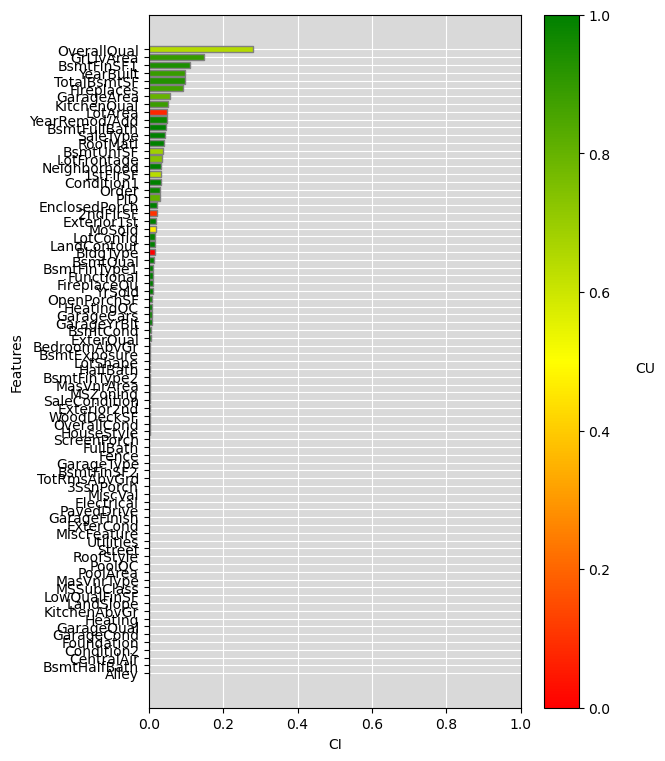

In [7]:
CIU_ames.plot_ciu(CIUres, figsize=(6,9))

In [8]:
ames_voc = {
    "Garage":[c for c in df.columns if 'Garage' in c],
    "Basement":[c for c in df.columns if 'Bsmt' in c],
    "Lot":list(df.columns[[3,4,7,8,9,10,11]]),
    "Access":list(df.columns[[13,14]]),
    "House_type":list(df.columns[[1,15,16,21]]),
    "House_aesthetics":list(df.columns[[22,23,24,25,26]]),
    "House_condition":list(df.columns[[20,18,21,28,19,29]]),
    "First_floor_surface":list(df.columns[[43]]),
    "Above_ground_living area":[c for c in df.columns if 'GrLivArea' in c]
}
CIU_ames.vocabulary = ames_voc

In [9]:
top_res = CIU_ames.explain_voc(ames_instance, nsamples=1000)
display(top_res)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
Garage,0.063781,0.837300,0.021513,Price,740.222046,Garage,685.162415,750.920959,"[59, 60, 61, 62, 63, 64, 65]","[1, 103, 0, 2, 224, 5, 5]",0.5,None,None
Basement,0.235304,0.900605,0.094264,Price,740.222046,Basement,521.736511,764.335022,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]","[0, 5, 1, 2, 941, 6, 0, 81, 847, 1, 1]",0.5,None,None
Lot,0.062169,0.796663,0.018443,Price,740.222046,Lot,689.159302,753.255127,"[3, 4, 7, 8, 9, 10, 11]","[6, 20, 1, 0, 1, 0, 4]",0.5,None,None
Access,0.066235,0.998431,0.033013,Price,740.222046,Access,672.041138,740.329163,"[13, 14]","[6, 2]",0.5,None,None
House_type,0.071816,0.696864,0.014138,Price,740.222046,House_type,688.624329,762.667114,"[1, 15, 16, 21]","[2700, 2, 4, 55]",0.5,None,None
House_aesthetics,0.056205,0.938650,0.024654,Price,740.222046,House_aesthetics,685.829773,743.777100,"[22, 23, 24, 25, 26]","[3, 1, 5, 5, 4]",0.5,None,None
House_condition,0.448298,0.778796,0.124984,Price,740.222046,House_condition,380.266052,842.461487,"[20, 18, 21, 28, 19, 29]","[111, 6, 55, 2, 4, 4]",0.5,None,None
Electrical,0.000295,1.000000,0.000147,Price,740.222046,Electrical,739.918396,740.222046,[43],[4],0.5,None,None
GrLivArea,0.149149,0.894286,0.058807,Price,740.222046,GrLivArea,602.705200,756.477905,[47],[711],0.5,None,None


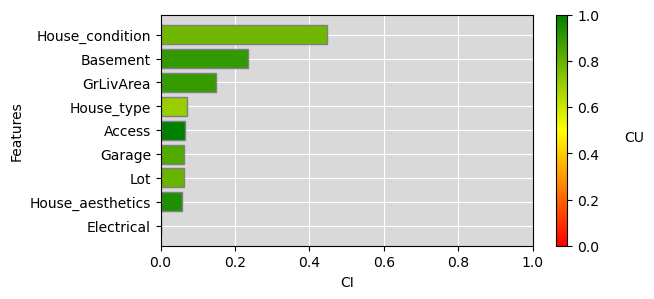

In [10]:
CIU_ames.plot_ciu(top_res, figsize=(6,3))

One way of explaining intermediate concepts is to just indicate the target concept (intermediate concept):

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
YearBuilt,0.224599,0.889584,0.087500,Price,740.222046,YearBuilt,650.217224,751.393555,[20],[111],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
OverallQual,0.642648,0.647663,0.094896,Price,740.222046,OverallQual,553.617737,841.737061,[18],[6],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
YearRemod/Add,0.110020,0.969996,0.051709,Price,740.222046,YearRemod/Add,690.913513,741.747253,[21],[55],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
ExterQual,0.010791,1.000000,0.005395,Price,740.222046,ExterQual,735.350220,740.222046,[28],[2],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
OverallCond,0.004773,0.244806,-0.001218,Price,740.222046,OverallCond,739.692688,741.855042,[19],[4],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
ExterCond,0.000082,1.000000,0.000041,Price,740.222046,ExterCond,740.184387,740.222046,[29],[4],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"


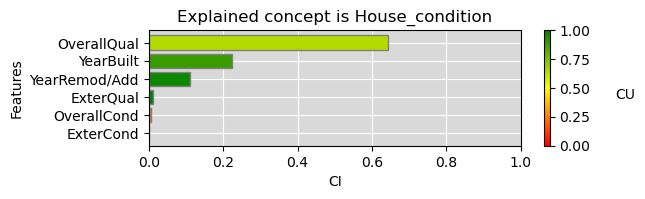

In [11]:
tconcept = "House_condition"
res = CIU_ames.explain(ames_instance, target_concept=tconcept, nsamples=1000)
display(res)
CIU_ames.plot_ciu(res, figsize=(6,1.5), main=f"Explained concept is {tconcept}")

However, for concistency of CIU values and for avoiding to re-calculate CIU for the target intermediate concept, it is better to pass the existing CIU result for the target concept (that may include rows also for other features or intermediate concepts).

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
YearBuilt,0.218904,0.889584,0.085281,Price,740.222046,YearBuilt,650.217224,751.393555,[20],[111],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
OverallQual,0.623371,0.647663,0.092049,Price,740.222046,OverallQual,553.617737,841.737061,[18],[6],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
YearRemod/Add,0.109983,0.969996,0.051692,Price,740.222046,YearRemod/Add,690.913513,741.747253,[21],[55],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
ExterQual,0.010541,1.000000,0.005270,Price,740.222046,ExterQual,735.350220,740.222046,[28],[2],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
OverallCond,0.004678,0.244806,-0.001194,Price,740.222046,OverallCond,739.692688,741.855042,[19],[4],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"
ExterCond,0.000081,1.000000,0.000041,Price,740.222046,ExterCond,740.184387,740.222046,[29],[4],0.5,House_condition,"[20, 18, 21, 28, 19, 29]"


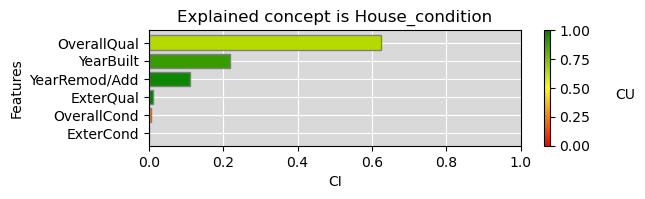

In [12]:
tconcept = "House_condition"
res = CIU_ames.explain(ames_instance, nsamples=1000, target_concept=tconcept, target_ciu=top_res)
display(res)
CIU_ames.plot_ciu(res, figsize=(6,1.5), main=f"Explained concept is {tconcept}")

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
BsmtQual,0.064998,1.000000,0.032499,Price,740.222046,BsmtQual,724.453613,740.222046,[31],[0],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtCond,0.023584,1.000000,0.011792,Price,740.222046,BsmtCond,734.500488,740.222046,[32],[5],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtExposure,0.019241,1.000000,0.009620,Price,740.222046,BsmtExposure,735.554260,740.222046,[33],[1],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtFinType1,0.052234,1.000000,0.026117,Price,740.222046,BsmtFinType1,727.550171,740.222046,[34],[2],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtFinSF1,0.472625,0.942100,0.208948,Price,740.222046,BsmtFinSF1,632.202515,746.860718,[35],[941],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtFinType2,0.017719,0.000000,-0.008860,Price,740.222046,BsmtFinType2,740.222046,744.520691,[36],[6],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtFinSF2,0.004146,0.000000,-0.002073,Price,740.222046,BsmtFinSF2,740.222046,741.227844,[37],[0],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtUnfSF,0.160256,0.684075,0.029499,Price,740.222046,BsmtUnfSF,713.626709,752.504517,[38],[81],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
TotalBsmtSF,0.409551,0.932756,0.177236,Price,740.222046,TotalBsmtSF,647.546753,746.903137,[39],[847],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"
BsmtFullBath,0.197722,1.000000,0.098861,Price,740.222046,BsmtFullBath,692.254944,740.222046,[48],[1],0.5,Basement,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]"


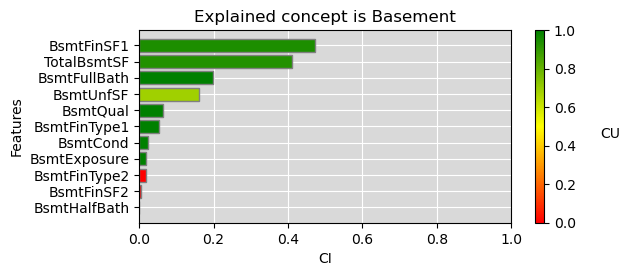

In [13]:
tconcept = "Basement"
res = CIU_ames.explain(ames_instance, target_concept=tconcept, target_ciu=top_res, nsamples=1000)
display(res)
CIU_ames.plot_ciu(res, figsize=(6,2.5), main=f"Explained concept is {tconcept}")

THERE SHOULD STILL BE A TEST FOR USING INPUT CONCEPTS TOGETHER WITH A TARGET CONCEPT! I.E. calling ``explain_voc``. 